In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# fix random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Model specification

## Data

In [12]:
batch_size = 128
lr = 3e-4
log_interval = 10
num_epochs = 15

In [13]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

dataset1 = datasets.MNIST("data", train=True, download=True, transform=transform)
dataset2 = datasets.MNIST("data", train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

In [14]:
indexes = dict()
for index, target in enumerate(dataset1.targets.tolist()):
    if target not in indexes:
        indexes[target] = [index]
    else:
        indexes[target].append(index)

In [15]:
subsampled_indexes = dict()
for i in range(10):
    subsampled_indexes[i] = []
subsampled_data = []
subsampled_target = []
for key, sub_indexes in indexes.items():
    np_sub_indexes = np.random.choice(sub_indexes, 50, replace=False)
    subsampled_indexes[key] = np_sub_indexes
    for index in np_sub_indexes:
        data, target = dataset1.__getitem__(index)
        subsampled_data.append(torch.flatten(data))
        subsampled_target.append(target)
    

subsampled_data = torch.stack(subsampled_data)
subsampled_target = torch.tensor(subsampled_target)
subsampled_data.shape, subsampled_target.shape

(torch.Size([500, 784]), torch.Size([500]))

## Basic optimization loop

In [79]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            #nn.Flatten(),
            nn.Linear(784, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
            #nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 784)
            #nn.Sigmoid()
        )
    
    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [63]:
def train(dataloader, model, criterion, optimizer, num_epochs):
    losses = []
    model.train()

    for epoch in tqdm(range(num_epochs)):
        running_loss = 0
        for x, y in dataloader:
            x = x.view(-1, 28*28).to(device)
            #print(x.shape)
            x_hat = model(x)

            loss = criterion(x_hat, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        loss = running_loss/len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.6f}")
        losses.append(loss)
    
    return losses

In [80]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = train(train_loader, model, criterion, optimizer, num_epochs)

  7%|▋         | 1/15 [00:17<04:04, 17.45s/it]

Epoch 1/15, Loss: 0.853989


 13%|█▎        | 2/15 [00:42<04:46, 22.07s/it]

Epoch 2/15, Loss: 0.661041


 20%|██        | 3/15 [01:04<04:22, 21.86s/it]

Epoch 3/15, Loss: 0.620674


 27%|██▋       | 4/15 [01:24<03:54, 21.32s/it]

Epoch 4/15, Loss: 0.603740


 33%|███▎      | 5/15 [01:47<03:38, 21.81s/it]

Epoch 5/15, Loss: 0.596372


 40%|████      | 6/15 [02:07<03:11, 21.30s/it]

Epoch 6/15, Loss: 0.590836


 47%|████▋     | 7/15 [02:27<02:45, 20.70s/it]

Epoch 7/15, Loss: 0.586452


 53%|█████▎    | 8/15 [02:47<02:23, 20.47s/it]

Epoch 8/15, Loss: 0.582871


 60%|██████    | 9/15 [03:05<01:58, 19.73s/it]

Epoch 9/15, Loss: 0.580033


 67%|██████▋   | 10/15 [03:22<01:33, 18.79s/it]

Epoch 10/15, Loss: 0.577833


 73%|███████▎  | 11/15 [03:39<01:13, 18.39s/it]

Epoch 11/15, Loss: 0.576112


 80%|████████  | 12/15 [03:59<00:56, 18.79s/it]

Epoch 12/15, Loss: 0.574790


 87%|████████▋ | 13/15 [04:18<00:37, 18.96s/it]

Epoch 13/15, Loss: 0.573724


 93%|█████████▎| 14/15 [04:36<00:18, 18.63s/it]

Epoch 14/15, Loss: 0.572846


100%|██████████| 15/15 [04:55<00:00, 19.69s/it]

Epoch 15/15, Loss: 0.572044


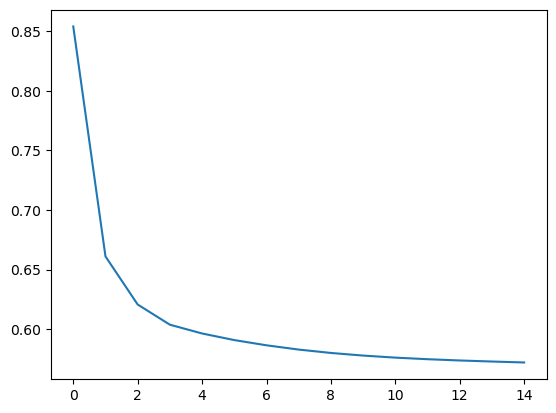

In [81]:
plt.plot(losses)
plt.show()

In [82]:
embeddings1 = model.encode(subsampled_data.to(device)).cpu().detach().numpy()

In [ ]:
# TODO

In [ ]:
embeddings2 = model.encode(subsampled_data).detach().numpy()

NameError: name 'embeddings2' is not defined

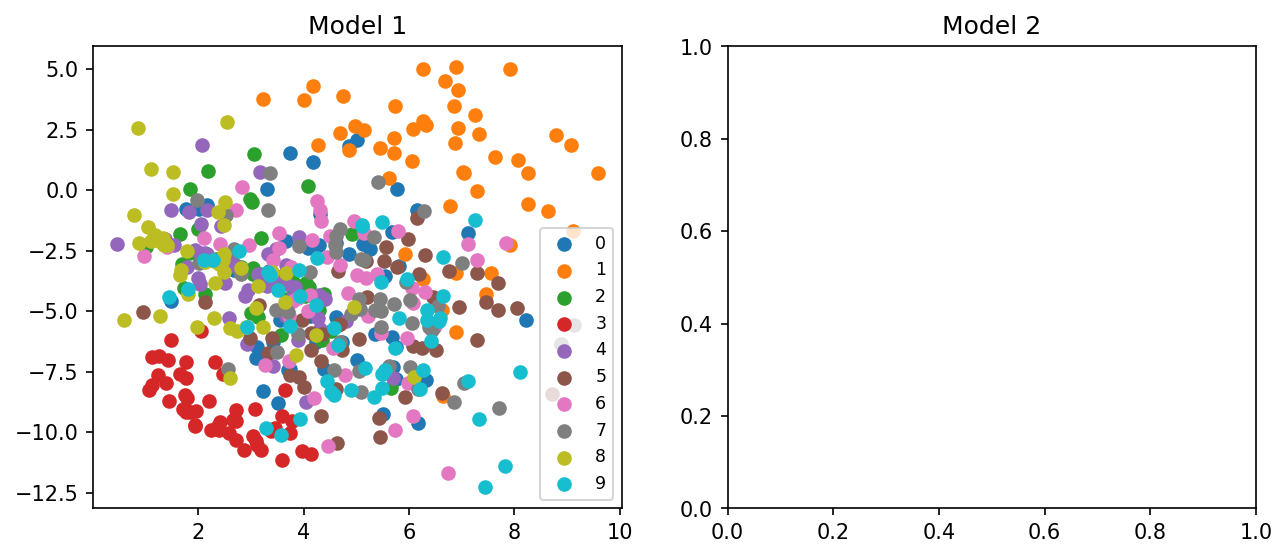

In [83]:
fig, axs = plt.subplots(1, 2, dpi=150, figsize=(10, 4))
cmap = plt.get_cmap("tab10")
axs[0].set_title("Model 1")
for i, (key, indexes) in enumerate(subsampled_indexes.items()):
    color = cmap(i / 10)
    axs[0].scatter(embeddings1[50*i: 50*(i+1), 0], embeddings1[50*i: 50*(i+1), 1], color=color, label=key)
axs[0].legend(fontsize="small")
axs[1].set_title("Model 2")
for i, (key, indexes) in enumerate(subsampled_indexes.items()):
    color = cmap(i / 10)
    axs[1].scatter(embeddings2[50*i: 50*(i+1), 0], embeddings2[50*i: 50*(i+1), 1], color=color, label=key)
axs[1].legend(fontsize="small")
plt.show()